## Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.  
Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.  

Значение метрики RMSE на тестовой выборке должно быть не больше 48.  

#### Вам нужно:  

Загрузить данные и выполнить их ресемплирование по одному часу.    
Проанализировать данные.    
Обучить разные модели с различными гиперпараметрами.   
Сделать тестовую выборку размером 10% от исходных данных.    
Проверить данные на тестовой выборке и сделать выводы.    
Данные лежат в файле taxi.csv.   
Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).    

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

import time
from sklearn.model_selection import (GridSearchCV,cross_val_score)
from sklearn.ensemble import RandomForestRegressor


In [2]:
try:
    data=pd.read_csv(r"C:\Users\Admin\Desktop\taxi.csv", index_col=[0], parse_dates=[0])
except:
    data=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.index.is_monotonic  

True

In [6]:
data.index.is_unique

True

## Анализ

<AxesSubplot:xlabel='datetime'>

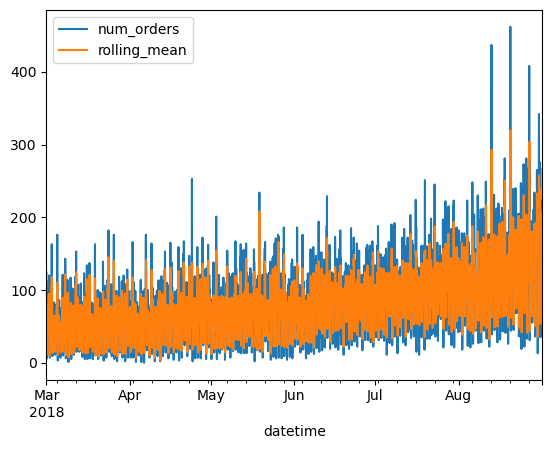

In [7]:
data.sort_index(inplace=True)
data=data.resample('1H').sum()
data['rolling_mean'] = data.rolling(3).mean()  
data.plot()

In [8]:
data=data.drop('rolling_mean', axis=1)

In [9]:
print(data.index.min(), data.index.max())

2018-03-01 00:00:00 2018-08-31 23:00:00


In [10]:
data = data['2018-08-01 00:00:00':'2018-08-31 00:00:00']

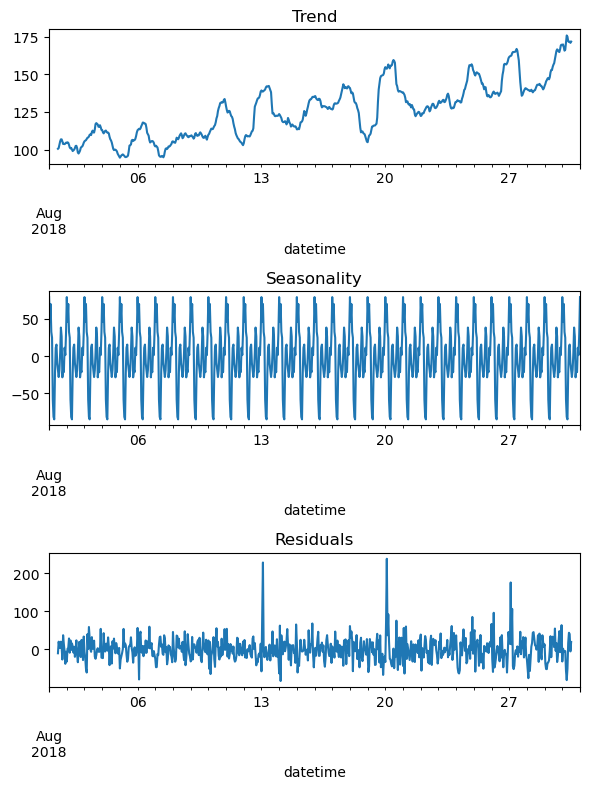

In [11]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Датасет содержит данные с марта по август 2018 года, наблюдается тенденция по увеличению числа заказов. Рассмотрим конец августа.

In [12]:
data = data['2018-08-20 00:00:00':'2018-08-30 00:00:00']

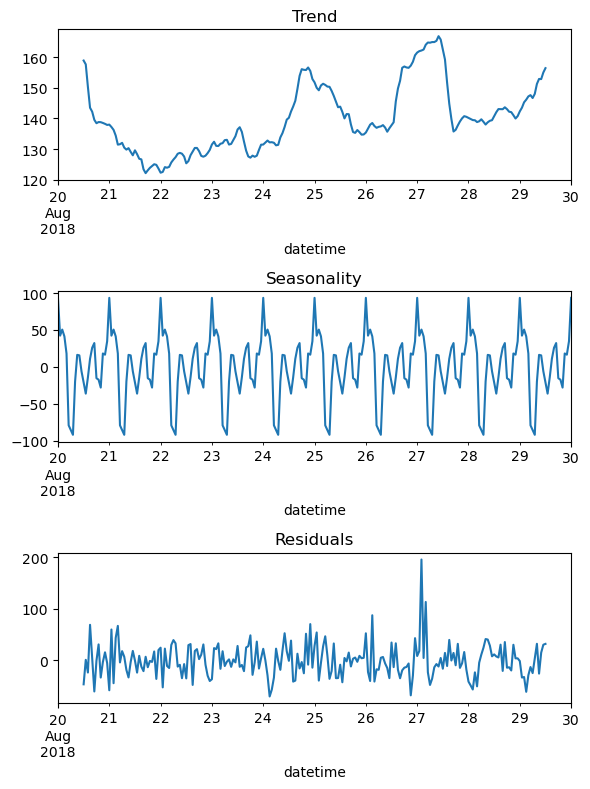

In [13]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

## Обучение

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

categor=['hour','dayofweek']

make_features(data, 1 ,24)
data = data.dropna()

train, test = train_test_split(data, shuffle=False, test_size=0.2)

train_new=train.copy()
test_new=test.copy()

valid, test = train_test_split(test, shuffle=False, test_size=0.5)

target_train = train['num_orders']
features_train = train.drop(['num_orders'] , axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'] , axis=1)
target_valid = valid['num_orders']
features_valid  = valid.drop(['num_orders'] , axis=1)

start = time.time()
model = LGBMRegressor(max_depth=10)


features_train[categor] = features_train[categor].astype("category")
features_test[categor] = features_test[categor].astype("category")
features_valid[categor] = features_valid[categor].astype("category")


model.fit(features_train,target_train)
predictions_train = model.predict(features_train)
predictions_valid = model.predict(features_valid)

print('LGBMRegressor')
LGBMRegressor_RMSE=round((mean_squared_error(target_valid, predictions_valid))**0.5,2)
print("RMSE валидационной выборки:", LGBMRegressor_RMSE)
end = time.time()
LGBMRegressor_fit_predict_time = end - start
print("Время обучения и предсказания:",round(LGBMRegressor_fit_predict_time,2))

LGBMRegressor
RMSE валидационной выборки: 56.65
Время обучения и предсказания: 0.1


In [15]:
def draw_plot(model_name):
    plt.plot(valid.index, predictions_valid, 'o-r', label='Предсказанные')
    plt.plot(valid.index, target_valid, 'o-g', label='Реальные')
    plt.legend()
    plt.ylabel('Число заказов такси')
    plt.xlabel('Время')
    plt.title(model_name)
    plt.xticks(rotation=90)
    plt.show()

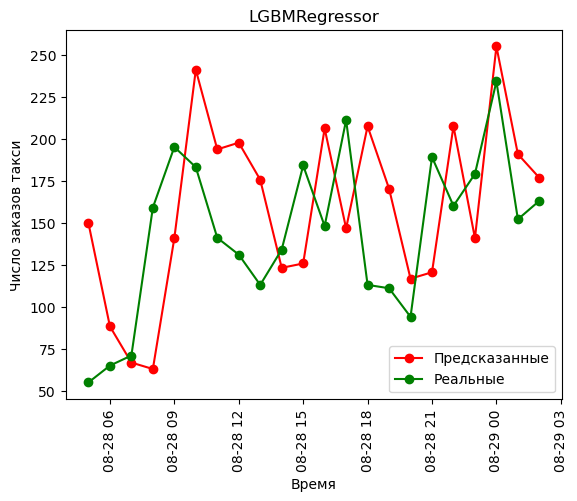

In [16]:
draw_plot('LGBMRegressor')

Получается, что большая разница между предсказанием и реальным числом заказов в 6 часов утра, модель считает, что заказов будет достаточно много, но на самом деле это не так. Еще модель ошиблась по поводу предсказания числа заказов в 12 часов ночи. Здесь наоборот, реальных заказов больше, чем было предсказано. 

In [17]:
start = time.time()
model = LinearRegression()
model.fit(features_train,target_train)
predictions_train = model.predict(features_train)
predictions_test = model.predict(features_test)
predictions_valid = model.predict(features_valid)
print('LinearRegression')
LinearRegression_RMSE=round((mean_squared_error(target_valid, predictions_valid))**0.5,2)
print("RMSE валидационной выборки:", LinearRegression_RMSE)
end = time.time()
LinearRegression_fit_predict_time = end - start
print("Время обучения и предсказания:",round(LinearRegression_fit_predict_time,2))

LinearRegression
RMSE валидационной выборки: 41.65
Время обучения и предсказания: 0.04


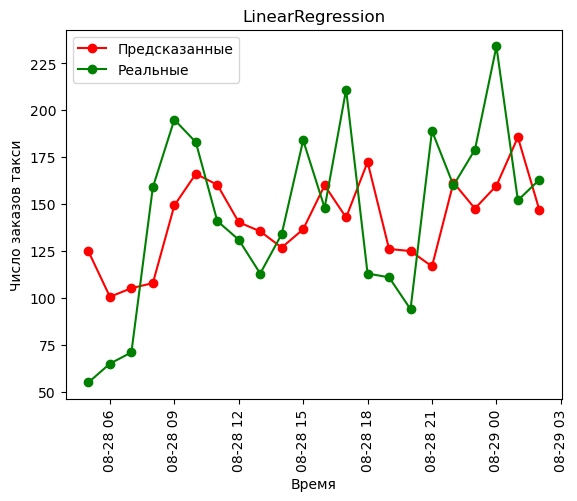

In [18]:
draw_plot('LinearRegression')

Те же самые ошибки в экстремальных значениях.

In [19]:
start = time.time()
target_train = train_new['num_orders']
features_train = train_new.drop(['num_orders'] , axis=1)
target_test = test_new['num_orders']
features_test = test_new.drop(['num_orders'] , axis=1)

model_CatBoostRegressor = CatBoostRegressor(random_state = 1234, verbose = False)
parametrs = {'depth' : range(1, 5, 1),
                'iterations' : range(100, 500, 100)
               }
my_cv=TimeSeriesSplit(n_splits=8).split(features_train)
grid = GridSearchCV(model_CatBoostRegressor, parametrs, cv=my_cv, scoring='neg_root_mean_squared_error')

grid.fit(features_train, target_train)
#CatBoost=grid
predictions_train = grid.predict(features_train)
end = time.time()
CatBoostRegressor_fit_predict_time = end - start
print('CatBoostRegressor')
print("Время обучения и предсказания:",round(CatBoostRegressor_fit_predict_time ,2))
CatBoostRegressor_RMSE=round((mean_squared_error(target_train, predictions_train))**0.5,2)
print("RMSE обучающей выборки:", CatBoostRegressor_RMSE)

CatBoostRegressor
Время обучения и предсказания: 46.21
RMSE обучающей выборки: 17.03


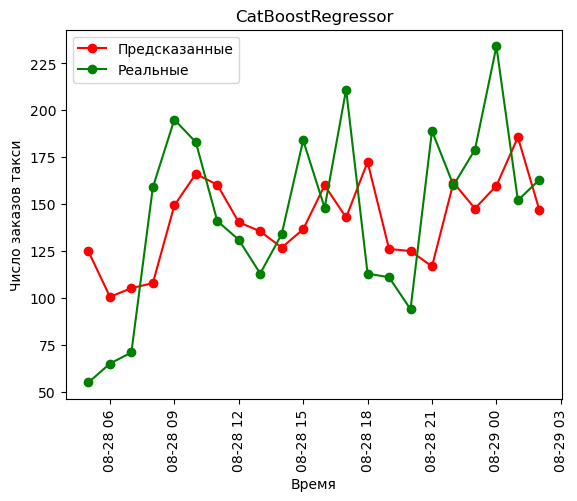

In [20]:
draw_plot('CatBoostRegressor')

Здесь проблема немного иная, модель не смогла предсказать, что спад будет резким.

In [21]:
model_RandomForestRegressor = RandomForestRegressor(random_state = 1234, verbose = False)
parametrs = {'max_depth' : range(1, 5, 1),
                'n_estimators' : range(10, 100, 10)
               }
my_cv=TimeSeriesSplit(n_splits=8).split(features_train)
start = time.time()
grid = GridSearchCV(model_RandomForestRegressor, parametrs, cv=my_cv, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
predictions_train = grid.predict(features_train)
end = time.time()
RandomForestRegressor_fit_predict_time = end - start
print('RandomForestRegressor')
print("Время обучения и предсказания:",round(RandomForestRegressor_fit_predict_time ,2))
RandomForestRegressor_RMSE=round((mean_squared_error(target_train, predictions_train))**0.5,2)
print("RMSE обучающей выборки:", RandomForestRegressor_RMSE)

RandomForestRegressor
Время обучения и предсказания: 38.63
RMSE обучающей выборки: 29.47


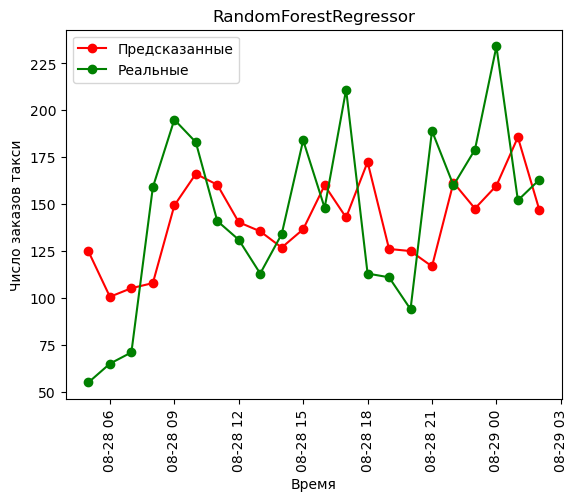

In [22]:
draw_plot('RandomForestRegressor')

Здесь все выглядит неплохо, опять же модель не смогла угадать очень маленькое количество заказов в 6 утра. 

In [23]:
stat=pd.DataFrame(data=[[LGBMRegressor_fit_predict_time,LGBMRegressor_RMSE],[LinearRegression_fit_predict_time,LinearRegression_RMSE],[CatBoostRegressor_fit_predict_time,CatBoostRegressor_RMSE],[RandomForestRegressor_fit_predict_time,RandomForestRegressor_RMSE]] ,
                  index=['LGBMRegressor','LinearRegression','CatBoostRegressor','RandomForestRegressor'],
                  columns=['fit&predict_time','RMSE']) 
print("Сравнение различных моделей")
stat

Сравнение различных моделей


,fit&predict_time,RMSE
LGBMRegressor,0.101129,56.65
LinearRegression,0.039587,41.65
CatBoostRegressor,46.213665,17.03
RandomForestRegressor,38.634384,29.47


## Тестирование

In [24]:
predictions_test=CatBoost.predict(features_test)
print('CatBoostRegressor')
CatBoostRegressor_RMSE=round((mean_squared_error(target_test, predictions_test))**0.5,2)
print("RMSE тестовой выборки:", CatBoostRegressor_RMSE)

CatBoostRegressor
RMSE тестовой выборки: 39.48


In [25]:

model=DummyRegressor()
model.fit(features_train, target_train)
predictions_train = model.predict(features_train)
predictions_test = model.predict(features_test)

print("DummyRegressor")
print("RMSE тестовой выборки: ",round((mean_squared_error(target_test, predictions_test))**0.5,2))


DummyRegressor
RMSE тестовой выборки:  51.35


Вывод:  
    Наилучшая модель для предсказания - библиотекой CatBoost (градиентный бустинг). Обучается дольше по сравнению с другими рассмотренными моделями, зато имеет хорошую точность предсказания. 
    RMSE тестовой выборки:  39.48     
    Провела сравнение с константной моделью, RMSE константной модели выше, чем у CatBoostRegressor.    
    Модель прошла проверку на адекватность.    
    RMSE константной модели на тестовой выборке:    51.35  

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48